In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
dataname="droplet"
ignore_index = -100 #Unet has the possibility of masking out pixels in the output image, we can specify the index value here (though not used)
gpuid=0

# --- unet params
#these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes= 2    #number of classes in the data mask that we'll aim to predict
in_channels= 3  #input channel of the data, RGB = 3
padding= True   #should levels be padded
depth= 5       #depth of the network 
wf= 6           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size= 3
patch_size=256

num_epochs = 30
edge_weight = 1.1 #edges tend to be the most poorly segmented given how little area they occupy in the training set, this paramter boosts their values along the lines of the original UNET paper
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms


import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

import torch
from torch import nn
import torch.nn.functional as F
import scipy.ndimage 

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix
import torch
from torch import nn
import torch.nn.functional as F

In [7]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#specify if we should use a GPU (cuda) or only the CPU
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')


class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out


_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(-0.5, 255.5, 255.5, -0.5)

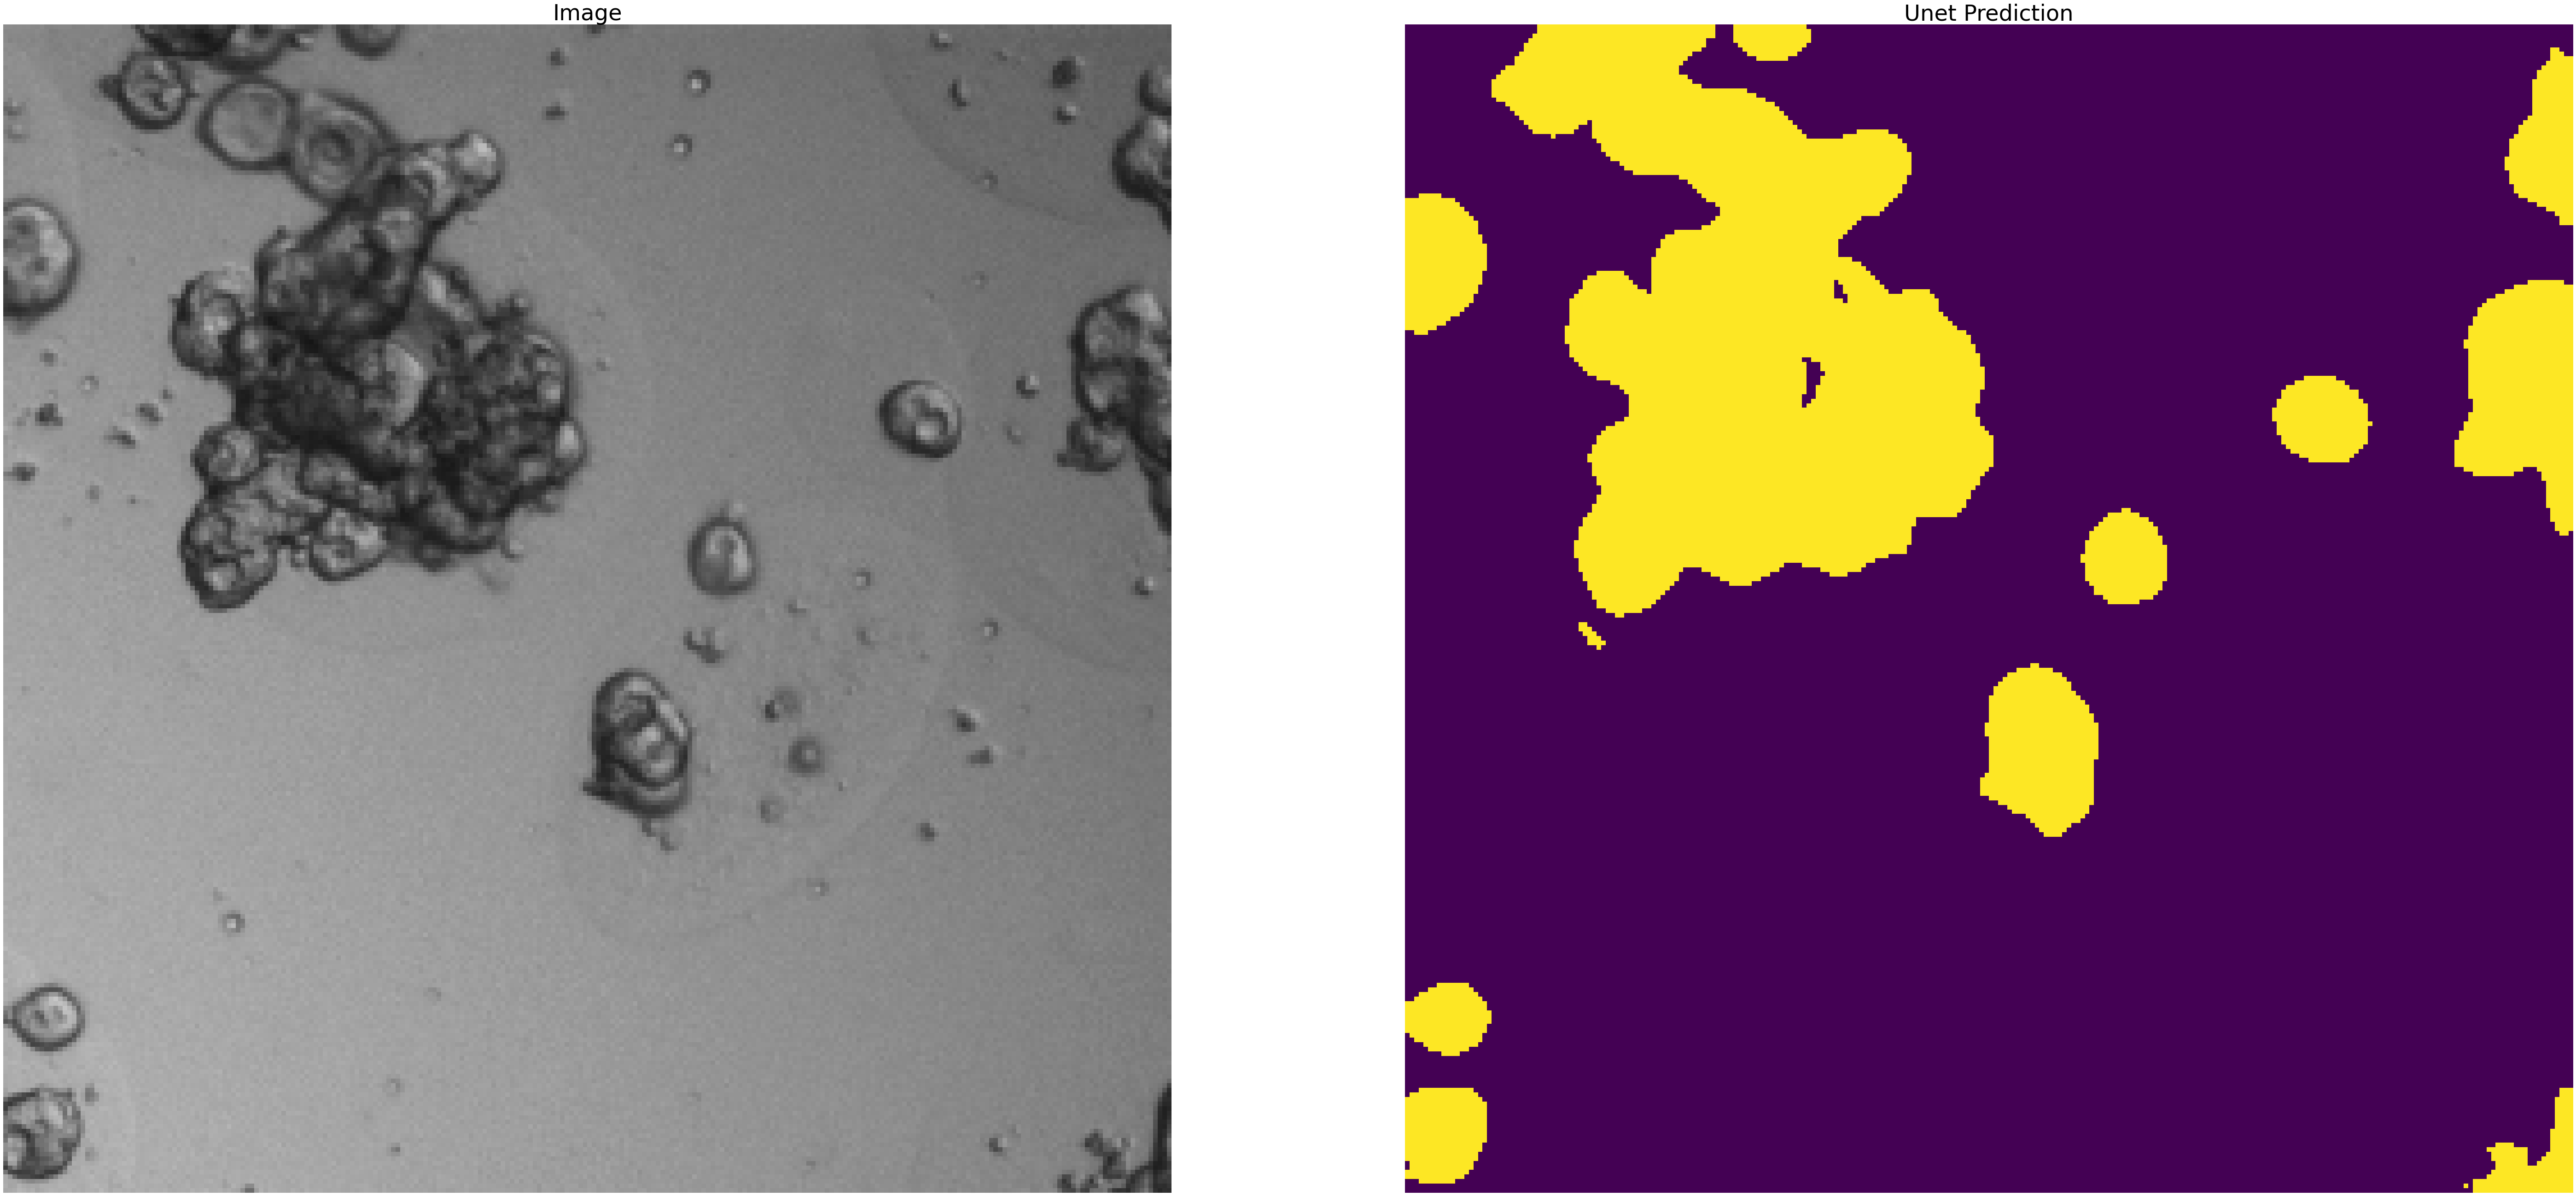

In [8]:
#load trained model

model = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding,depth=depth,wf=wf, up_mode=up_mode, batch_norm=batch_norm).to(device)
checkpoint = torch.load(F"/content/gdrive/MyDrive/droplet_unet_best_model.pth") #or put local location for the downloaded model
model.load_state_dict(checkpoint["model_dict"])
#load images and run the model on it
img = cv2.imread('/content/20210809_Incucyte_day6_4x580_droplet_2_0_3.png') #put location of your image here or use the sample iamge provided
#if you have a ground truth mask and would like to compare the prediction with it
#mask = cv2.imread('/content/20210703_CRC240_droplet_vs_bulk_4xdroplet_1_0_1_mask.png')
#mask = np.where(mask!=0,255,mask)
torch_tensor = torch.FloatTensor(img)
output=model(torch_tensor[None ,::].transpose_(1, 3).to(device))
output=output.detach().squeeze().cpu().numpy()
output=np.moveaxis(output,0,-1) 

#visualize result
plt.rcParams.update({'font.size': 40})
fig = plt.figure(figsize = (100,50))

plots=fig.add_subplot(1,2,1)
imgplot = plt.imshow(img)
plots.set_title('Image')
plt.axis('off')

plots =fig.add_subplot(1,2,2)
imgplot = plt.imshow(np.rot90(np.fliplr(np.argmax(output,axis=2))))
plots.set_title('Unet Prediction')
plt.axis('off')

# plots=fig.add_subplot(1,2,2)
# imgplot = plt.imshow(mask)
# plots.set_title('CP Prediction (GT)')
# plt.axis('off')
